<a href="https://en.wikipedia.org/wiki/Galindians" target="_blank"><img src="https://upload.wikimedia.org/wikipedia/commons/4/42/Flag_of_Widewuto.jpg" alt="IMAGE ALT TEXT HERE" width="480" border="10"/></a>

--------------------
galindia is a Jupyter notebook that provides some example code of how to combine phylogenies from [nextstrain.org](nextstrain.org) with baltic. This is still very much work in progress.

------------

Copyright 2017 [Gytis Dudas](https://twitter.com/evogytis). Licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).


In [1]:
try:
    import imp
    bt = imp.load_source('baltic', '/Users/evogytis/Documents/baltic/baltic.py')
except:
    import importlib.machinery
    import importlib.util
    loader = importlib.machinery.SourceFileLoader('baltic','/Users/evogytis/Documents/baltic/baltic.py')
    spec = importlib.util.spec_from_loader(loader.name, loader)
    bt = importlib.util.module_from_spec(spec)
    loader.exec_module(bt)

In [2]:
from IPython.display import HTML
import re,copy,json

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects

import numpy as np

try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
    
import requests
json_url='http://data.nextstrain.org/flu_seasonal_h3n2_ha_12y.json'
nx_tree=json.load(csio(requests.get(json_url).content))

tree=nx_tree['tree']
meta=nx_tree['meta']

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
json_meta={'file':meta,'traitName':'region'} ## if you want auspice stylings you can import the meta file used on nextstrain.org
ll=bt.loadJSON(tree,json_translation,json_meta) ## give loadJSON the name of the tree file, the translation dictionary and (optionally) the meta file

path='<iframe style="border: 0; width: 100%; height: 120px;" src="https://bandcamp.com/EmbeddedPlayer/track=2975389283/size=large/bgcol=333333/linkcol=e32c14/tracklist=false/artwork=small/transparent=true/" seamless><a href="http://marlonwilliams.bandcamp.com/track/vampire-again">Vampire Again by Marlon Williams</a></iframe>'

print('Done!')
HTML(path)


Tree height: 14.466876
Tree length: 1139.791008
annotations present

Numbers of objects in tree: 4614 (2086 nodes and 2528 leaves)

Done!


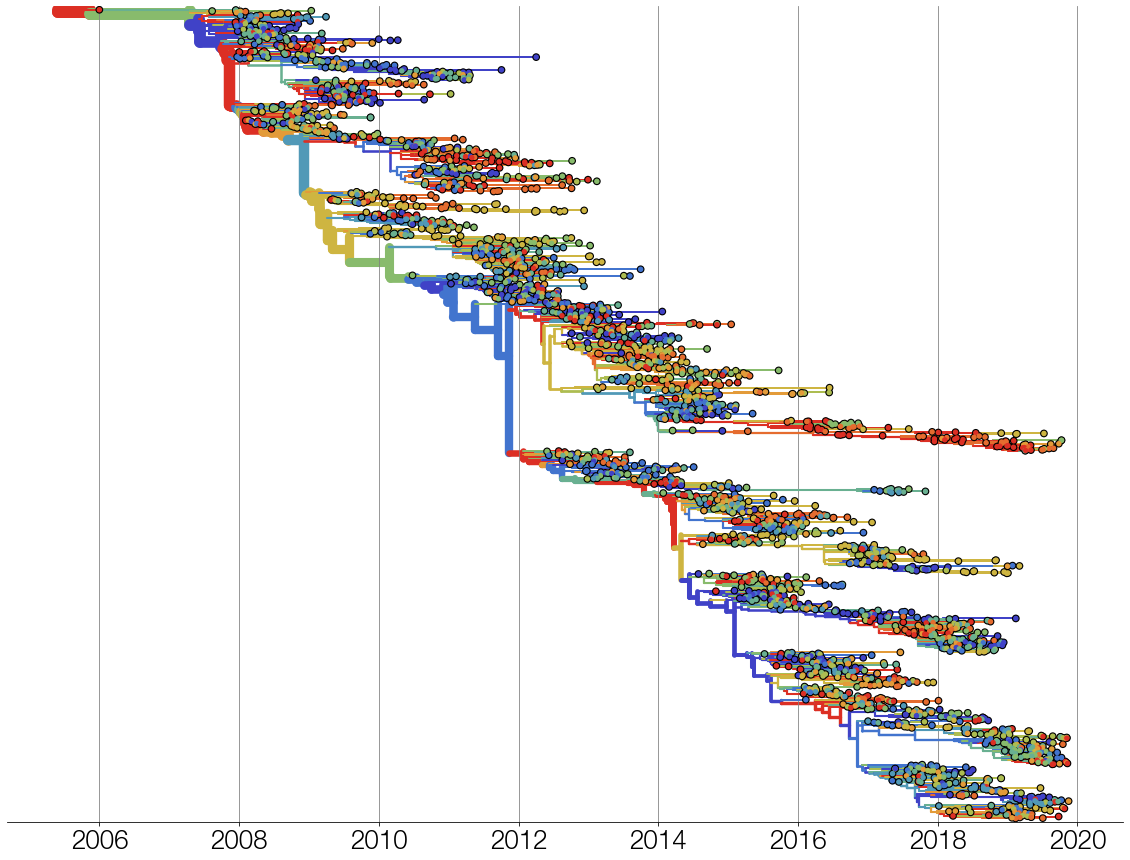

In [3]:
fig,ax = plt.subplots(figsize=(20,15),facecolor='w')

L=len(list(filter(lambda k: k.branchType=='leaf',ll.Objects)))

x_attr=lambda k: k.absoluteTime ## x coordinate will be absolute time of node
c_func=lambda k: ll.cmap[k.traits[json_meta['traitName']]] ## colour will be determined by the trait of choice, using the colour map defined by the meta json
b_func=lambda k: 2+10.0*len(k.leaves)/float(L) if k.branchType=='node' else 2 ## branch width is determined by how many descendants a node has, otherwise 2 (tips)
s_func=lambda k: 30 ## tip circles are constant size
su_func=lambda k: s_func(k)*2
cu_func=lambda k: 'k'
z_func=lambda k: 20000 if k.branchType=='leaf' else 100-len(k.leaves) ## branches with more descendants are lower along Z axis
kwargs={'solid_capstyle':'round'}

ll.plotTree(ax,x_attr=x_attr,branchWidth=b_func,colour_function=c_func,zorder_function=z_func,**kwargs) ## plot branches
ll.plotPoints(ax,x_attr=x_attr,size_function=s_func,
                    colour_function=c_func,zorder_function=lambda k:20002) ## plot coloured points at tips
ll.plotPoints(ax,x_attr=x_attr,size_function=su_func,
                    colour_function=cu_func,zorder_function=lambda k:20001) ## plot black points underneath tip circles

ax.set_ylim(-10,ll.ySpan+10)

[ax.spines[loc].set_visible(False) for loc in ['left','right','top']] ## no axes

ax.grid(axis='x',ls='-',color='grey')
ax.tick_params(axis='y',size=0)
ax.tick_params(axis='x',labelsize=26)
ax.set_yticklabels([])

plt.show()

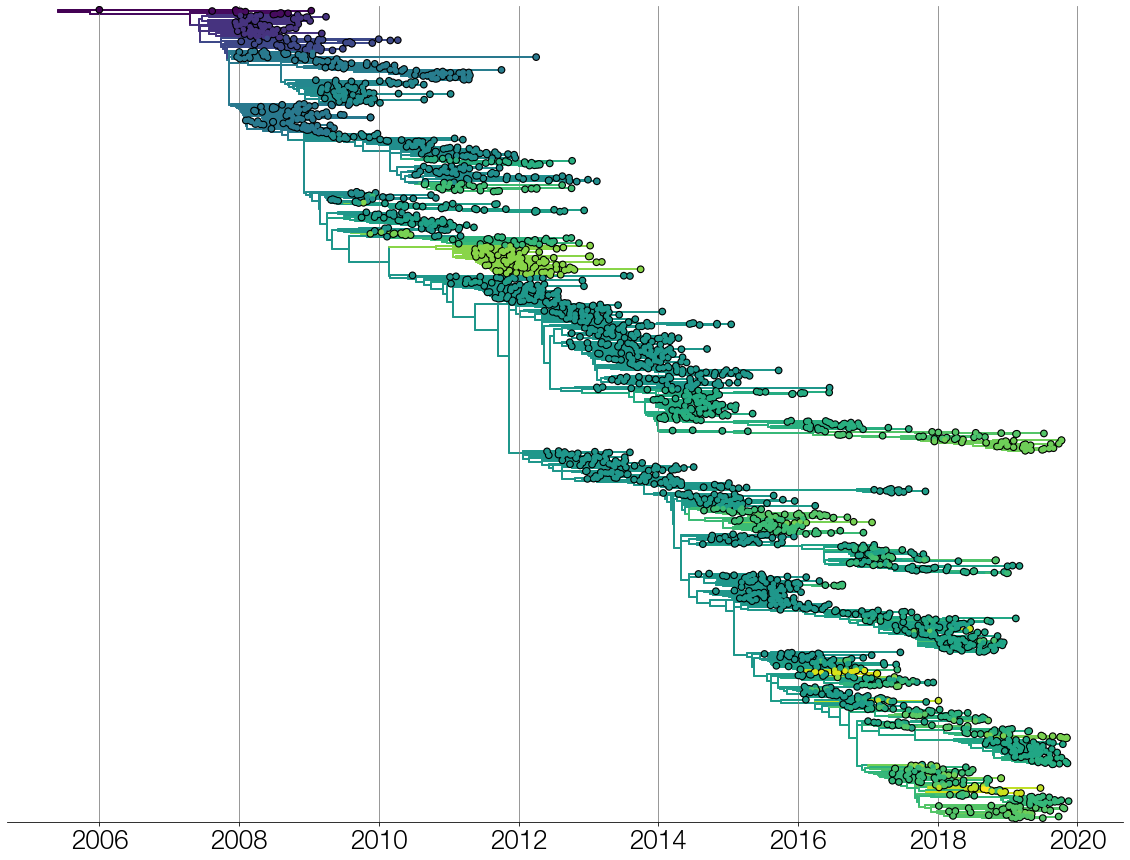

In [4]:
fig,ax = plt.subplots(figsize=(20,15),facecolor='w')

continuousTrait='cTiter'

titers=[k.traits[continuousTrait] for k in ll.Objects]
norm=mpl.colors.Normalize(min(titers),max(titers))
cmap=mpl.cm.viridis

x_attr=lambda k: k.absoluteTime
c_func=lambda k: cmap(norm(k.traits[continuousTrait])) if continuousTrait in k.traits else 'k'
b_func=lambda k: 2
s_func=lambda k: 30
su_func=lambda k: s_func(k)*2
cu_func=lambda k: 'k'
z_func=lambda k: 20000 if k.branchType=='leaf' else 100-len(k.leaves)
kwargs={'solid_capstyle':'round'}

ll.plotTree(ax,x_attr=x_attr,branchWidth=b_func,colour_function=c_func,zorder_function=z_func,**kwargs)
ll.plotPoints(ax,x_attr=x_attr,size_function=s_func,
                    colour_function=c_func,zorder_function=lambda k:20002)
ll.plotPoints(ax,x_attr=x_attr,size_function=su_func,
                    colour_function=cu_func,zorder_function=lambda k:20001)

ax.set_ylim(-10,ll.ySpan+10)

[ax.spines[loc].set_visible(False) for loc in ['left','right','top']] ## no axes

ax.grid(axis='x',ls='-',color='grey')
ax.tick_params(axis='y',size=0)
ax.tick_params(axis='x',labelsize=26)
ax.set_yticklabels([])

plt.show()

In [5]:
branchWidth=2
tipSize=30
traitName='region'
ll.root.parent.traits[traitName]='ancestor' ## add fake trait to root of the tree
loc_states=set([k.traits[traitName] for k in ll.Objects]+['ancestor'])
#tree_strings={loc:[] for loc in loc_states}
loc_trees={loc:[] for loc in loc_states}

for l in ll.Objects:
    k=l
    kp=l.parent
    
    ## get current node's and its parent's trait states
    kloc=k.traits[traitName]
    if traitName in k.parent.traits:
        kploc=kp.traits[traitName]
        kpc=kploc
    else:
        kploc='ancestor'
        kpc='ancestor'

    kc=kloc
    
    ## if states do not match
    if kc!=kpc:
        
        ## extracting trait-specific subtrees is done by specifying a condition which is used to determine if a branch will be visited during a tree traversal and in this case is only called on the branches whose states are not the same as their parent (i.e. they have migrated) and as such represent the fates of lineages in the new state following a change
        subtree=ll.subtree(k,traverse_condition=lambda x:x.traits[traitName]==kc) ## this function returns a new baltic tree object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the trait value state of k
        if subtree:
            #tree_strings[kc].append(subtree.toString()) ## remember subtree string, subtree object itself
            loc_trees[kc].append((kpc,k.parent.index,subtree)) ## remember parent location, parent id and subtree itself
            
print('Done!')

Done!


In [6]:
cumulative_y=0
for loc in sorted(loc_states,key=lambda q:sum([sum([o.length for o in T[2].Objects]) for T in loc_trees[q]])): ## iterate over trait values
    for t,tr in enumerate(sorted(loc_trees[loc],key=lambda x:(-x[2].root.absoluteTime,len(x[2].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
        origin,parent,loc_tree=tr ## get origin of subtree, subtree itself
        if len([ob for ob in loc_tree.Objects if isinstance(ob,bt.leaf)])>0: ## proceed only if there's at least one tip in subtree
            loc_tree.drawTree()
            for w in loc_tree.Objects: ## iterate over subtree
                w.traits['y']=w.y+cumulative_y ## adjust y coordinates

            cumulative_y+=max([x.y for x in loc_tree.Objects])+2 ## increment y displacement

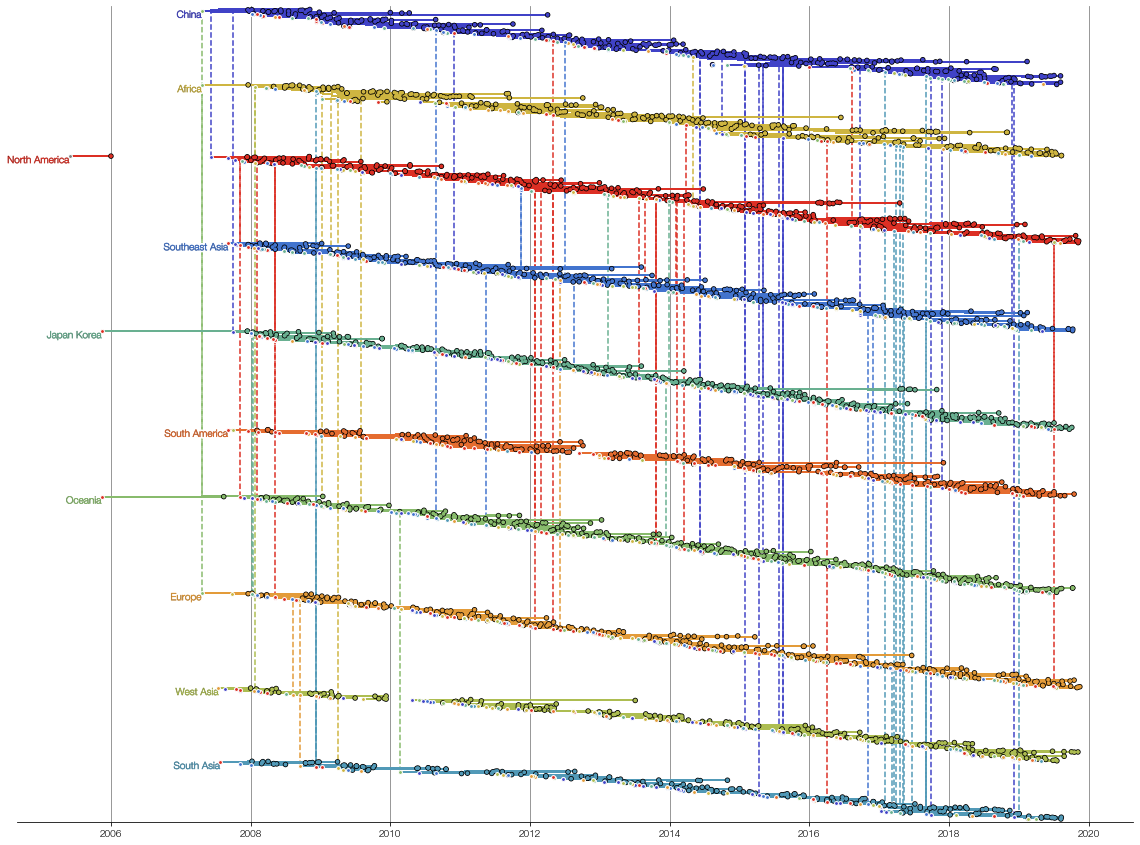

In [7]:
fig,ax = plt.subplots(figsize=(20,15),facecolor='w')

branchWidth=2
tipSize=15

mostRecent=max([k.absoluteTime for k in ll.Objects])
descent=ll.getBranches(lambda k: k.absoluteTime==mostRecent)

trunk_indices=[]
while descent:
    trunk_indices.append(descent.index)
    descent=descent.parent
trunk_indices.append(ll.root.index)

# trunk=ll.reduceTree([k for k in ll.Objects if k.absoluteTime==mostRecentTip])
# trunk_indices=[k.index for k in trunk.Objects]

cumulative_y=0
for loc in sorted(loc_states,key=lambda q:sum([sum([o.length for o in T[2].Objects]) for T in loc_trees[q]])): ## iterate over trait values
    
    fc='grey'
    if loc in ll.cmap: ## if there's a colour map available - use it
        fc=ll.cmap[loc]

    effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground=fc)] ## black text, white outline

    for t,tr in enumerate(sorted(loc_trees[loc],key=lambda x:(-x[2].root.absoluteTime,len(x[2].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
        origin,parent,loc_tree=tr ## get origin of subtree, subtree itself
        
        oriC='grey'
        if origin in ll.cmap:
            oriC=ll.cmap[origin] ## get colour of subtree's origin location
        
        if len([ob for ob in loc_tree.Objects if isinstance(ob,bt.leaf)])>0: ## proceed only if there's at least one tip in subtree
            ## identify branch on the trunk
            if loc_tree.root.index in trunk_indices: ## if subtree's root is on the trunk 
                for candidate in loc_trees[origin]: ## iterate through all subtrees in the parent's location
                    candidateOrigin,candidateParent,candidateSubtree=candidate ## extract information from entry
                    if parent in [r.index for r in candidateSubtree.Objects]: ## if subtree's parent's index is in subtree
                        subtree_x=loc_tree.root.absoluteTime ## x coordinate of descendant subtree
                        subtree_y=loc_tree.root.y+cumulative_y ## y coordinate of descendant subtree
                        subtree_parent_y=candidateSubtree.getBranches(lambda k: k.index==parent).traits['y'] ## y coordinate of subtree's parent
                        ax.plot([subtree_x,subtree_x],[subtree_y,subtree_parent_y],ls='--',color=oriC) ## plot dashed line connecting the two
            
            if t==len(loc_trees[loc])-1:
                ax.text(loc_tree.root.absoluteTime,loc_tree.root.y+cumulative_y,'%s'%(loc),ha='right',va='top',path_effects=effects)
            
            for w in loc_tree.Objects: ## iterate over subtree
                if w.traits[traitName]=='ancestor':
                    c='grey'
                else:
                    c=ll.cmap[w.traits[traitName]]
                y=w.y+cumulative_y
                x=w.absoluteTime
                if y!=None:
                    if w.parent!=None:
                        xp=w.parent.absoluteTime
                        yp=w.parent.y
                    else:
                        xp=x
                        yp=y+cumulative_y

                    if isinstance(w,bt.leaf): ## if leaf - plot tip circle
                        ax.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=100)
                        ax.scatter(x,y,s=tipSize*2,facecolor='k',edgecolor='none',zorder=99)

                    elif isinstance(w,bt.node): ## if node - plot vertical bar
                        yl=w.children[0].y+cumulative_y
                        yr=w.children[-1].y+cumulative_y
                        
                        ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98) ## plot vertical bar
                        
                    ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98) ## plot branch
            
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y

            ax.scatter(oriX,oriY,15,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin

            cumulative_y+=max([x.y for x in loc_tree.Objects])+2 ## increment y displacement

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom']

ax.grid(axis='x',ls='-',color='grey')
ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])
ax.set_ylim(-15,cumulative_y+15)

plt.show()

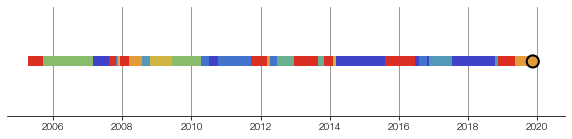

In [8]:
fig,ax = plt.subplots(figsize=(10,2),facecolor='w')

trunk=ll.reduceTree([ll.getBranches(lambda k: k.absoluteTime==mostRecent)])
L=len([k for k in trunk.Objects if k.branchType=='leaf'])

for k in trunk.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## x position is absolute time
    y=k.y ## y position
    
    xp=k.parent.absoluteTime ## get x position of current branch's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
        
    c='k'
    if json_meta['traitName'] in k.traits:
        c=ll.cmap[k.traits[json_meta['traitName']]] ## get colour
    
    branchWidth=10
    
    if k.branchType=='leaf': ## leaf
        s=100 ## tip size fixed
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s*2,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif k.branchType=='node': ## if node...
        branchWidth+=0.0*len(k.leaves)/float(L)
        
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9,solid_capstyle='round')
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
ax.set_ylim(-1,trunk.ySpan+1)

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom']

ax.grid(axis='x',ls='-',color='grey')
ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])

plt.show()